----

### **Assignment** : Advance Machine learning - Assignment 4 

---



  **Topic**: Apply RNNs to time-series data

  **Author**:  Khushboo Yadav

  **Date**:  Apr 28,2021

----

### **Introduction**



####**Data**

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

**RNN:**

RNNs are a powerful and robust type of neural network, and belong to the most promising algorithms in use because it is the only one with an internal memory.
Because of their internal memory, RNN’s can remember important things about the input they received, which allows them to be very precise in predicting what’s coming next. This is why they're the preferred algorithm for sequential data like time series, speech, text, financial data, audio, video, weather and much more. Recurrent neural networks can form a much deeper understanding of a sequence and its context compared to other algorithms.


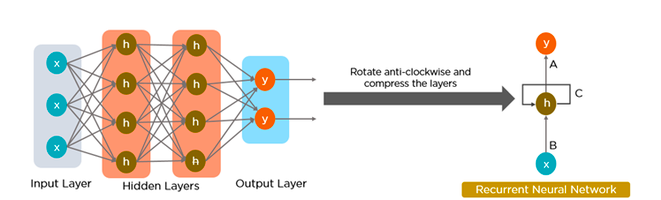

where x is the input, h is the hidden state values and y is the predicted output.Here A, B and C are parameters of the network.

 

Below diagram shows the flow of RNN :

In RNN, the input at a particular time stamp(t) is the current input at time t as well as the output of the previous hidden state i.e. h(t-1). There is always a looping of inputs at very time stamp. 


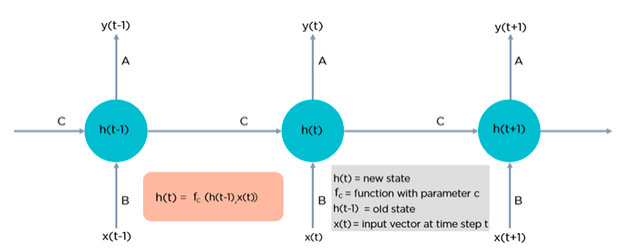

### **Goal**

To apply different methods to improve the performance of time-series forecasting problem . 


###**Approach**
#### High-level Approach to evaluate different methods to improve the performance on time-seies forecasting problem:


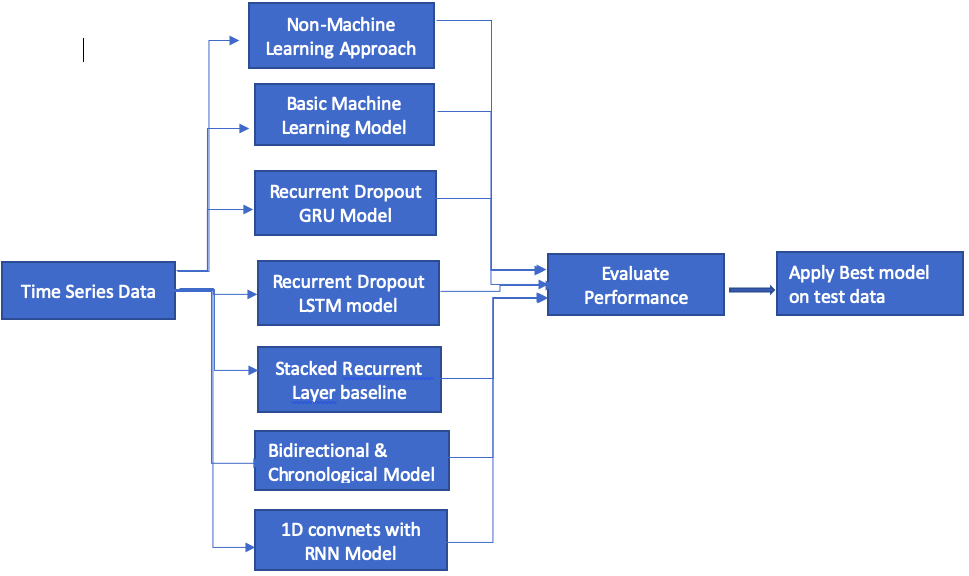

### **1. Reading Data**

In [ ]:
#Data Analysis
import os

data_dir = '/content/drive/MyDrive/Colab Notebooks/Climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
# converting 420,451 lines of data into a Numpy array:

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

 ### **2. Data Exploration**
It has 420451 lines of data with headers like date time,  temperature in degrees, percentage of rh etc.
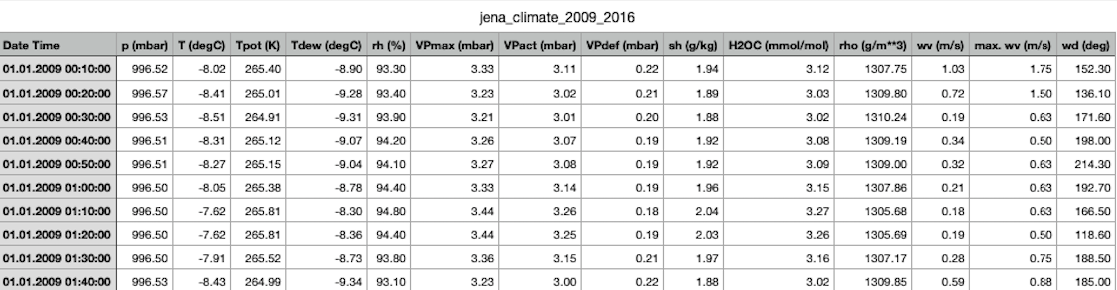

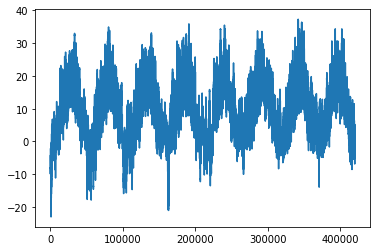

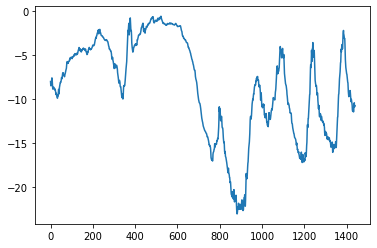

In [ ]:
#plotting the temperature timeseries
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

plt.plot(range(1440), temp[:1440])
plt.show()



### **3. Data Preparation**

In [ ]:
#Normalizing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

#Generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#using our abstract generator function to instantiate three generators, one for training, one for validation and one for testing

lookback = 1440
step = 6
delay = 144
batch_size = 128       

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### **4.  Simple Non- Machine Learning Approach**

**Mean Absolute Error (MAE)** refers to a the results of measuring the difference between two continuous variables.**MAE** tells us how big of a**error** we can expect from the forecast on average.

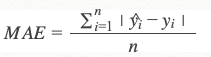


"High" MAE itself is relative and varies according to the data and there could be multiple factors contributing towards it.




In [ ]:


def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()



0.2897359729905486


 #### **4.1 Observations on Non-Machine learning Model:**
1. We get a MAE result of 0.289735(almost 0.29).
2. It gives an average absolute error of 0.29 * temperature_std degrees Celsius, i.e. 2.57˚C. 
3. MAE is not optimal and we should try to improve the performance by building a model with less MAE.

Let's build a basic machine learning model in order to set the performance baseline.


### **5. Simple Machine Learning Model**

Simple Machine Learning Model helps to establish baseline before trying machine-learning approaches.
These Models turns out to be very useful since they are simple and cheap and most importantly helps in creating baseline for the performance for other complex and expensive models.
  

Epoch 1/20
500/500 [==============================] - 12s 23ms/step - loss: 1.7668 - val_loss: 0.4626
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4643 - val_loss: 0.3053
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2991 - val_loss: 0.3075
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2713 - val_loss: 0.3247
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2604 - val_loss: 0.3062
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2455 - val_loss: 0.3059
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2406 - val_loss: 0.3151
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2335 - val_loss: 0.3437
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2295 - val_loss: 0.3427
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - loss: 0.221

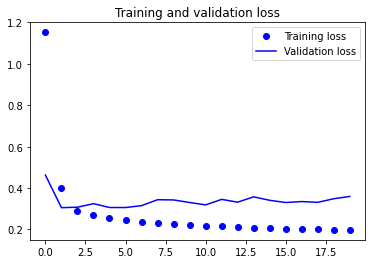

In [ ]:

#Machine Learning Approach
#first fully connected approach
#flatten the time series

import warnings
warnings.filterwarnings("ignore")
import random

random.seed(1001)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))# flattening the time series
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

#plotting loss charts for validation and training

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()






#### **5.1 Observations on Simple Machine learning model:**
1. Validation loss(MAE) remains in the range of 0.30's.
2. The performance is better however ,not good enough in comparison to the non-machine learning model.
3. We need to improve this model by reducing the overfitting and loss.


----
----

### **6. RNN with LSTM and GRU**


Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is similar to a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate.It is small then GRU is preferred otherwise LSTM for the larger dataset.

The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU's got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate.

The key difference between GRU and LSTM is that GRU's bag has two gates that are reset and update while LSTM has three gates that are input, output, forget. GRU is less complex than LSTM because it has less number of gates.






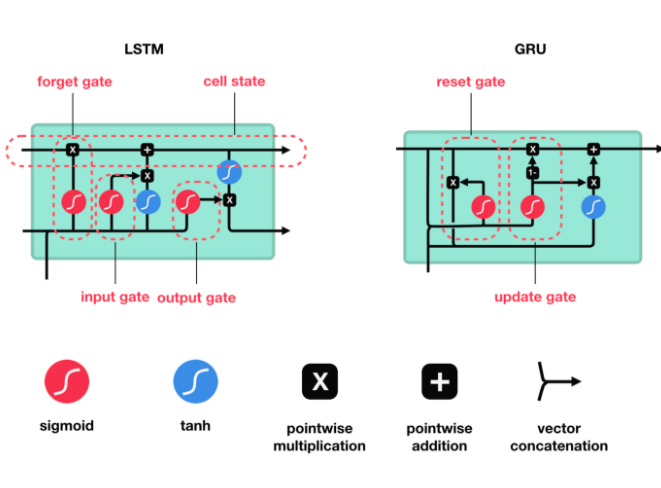




#### **6.1 Gated Recurrent Unit cell (GRU)**

GRUs train faster and perform better than LSTMs on less training data .
GRUs are simpler and thus easier to modify, for example adding new gates in case of additional input to the network. It's just less code in general.
LSTMs should in theory remember longer sequences than GRUs and outperform them in tasks requiring modeling long-distance relations.

Epoch 1/20
500/500 [==============================] - 71s 139ms/step - loss: 0.3389 - val_loss: 0.2752
Epoch 2/20
500/500 [==============================] - 67s 135ms/step - loss: 0.2852 - val_loss: 0.2659
Epoch 3/20
500/500 [==============================] - 68s 136ms/step - loss: 0.2778 - val_loss: 0.2667
Epoch 4/20
500/500 [==============================] - 70s 140ms/step - loss: 0.2726 - val_loss: 0.2627
Epoch 5/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2692 - val_loss: 0.2632
Epoch 6/20
500/500 [==============================] - 71s 142ms/step - loss: 0.2620 - val_loss: 0.2690
Epoch 7/20
500/500 [==============================] - 69s 138ms/step - loss: 0.2591 - val_loss: 0.2668
Epoch 8/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2535 - val_loss: 0.2708
Epoch 9/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2481 - val_loss: 0.2709
Epoch 10/20
500/500 [==============================] - 70s 140ms/step - l

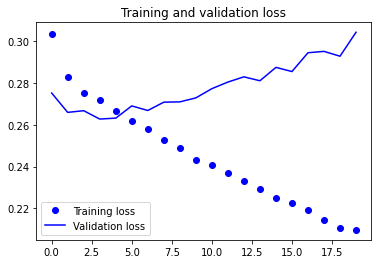

Val loss: 0.2730131447315216
train loss: 0.21171769499778748


In [ ]:
# first reccurent baseline with GRU

warnings.filterwarnings("ignore")

random.seed(2001)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_GRU = Sequential()
model_GRU.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model_GRU.add(layers.Dense(1))

model_GRU.compile(optimizer=RMSprop(), loss='mae')
history_GRU = model_GRU.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)



loss_GRU = history_GRU.history['loss']
val_loss_GRU = history_GRU.history['val_loss']

epochs = range(len(loss_GRU))

#plotting loss charts for validation and training 
plt.figure()

plt.plot(epochs, loss_GRU, 'bo', label='Training loss')
plt.plot(epochs, val_loss_GRU, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation of loss on validation dataset

val_loss_GRU = model_GRU.evaluate_generator(val_gen, steps=50)
print('Val loss:', val_loss_GRU)
loss_GRU = model_GRU.evaluate_generator(train_gen, steps=50)
print('train loss:', loss_GRU)


In [ ]:
test_loss = model_GRU.evaluate_generator(test_gen, steps=929)
print('test loss for base machine learning model:', test_loss)

test loss for base machine learning model: 0.31405189633369446


#### **6.2 Observations on the Basic GRU model:**

1. After epoch 3  , we can see that model starts to overfits.
2. Validation loss reachs to 0.3013 when Training goes to 0.2103 , indicating higher variation.
3. If we consider MAE of ~0.2629 , it gives a mean absolute error of 2.3313˚C after de-normalization.

We need to improve the network to first address the problem of overfitting .Let's begin with applying recurrent dropouts to regularize the model.


----
----

### **7. Recurrent Dropout with GRU:**

In order to overcome the above problem of overfitting we can use recurrent dropouts.

 In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning*, determined the proper way to use dropout with a recurrent network: the same dropout mask should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep.
 <br>


#### **Approach:**

 We have evaluated below 3 types of recurrent dropouts with GRU:-


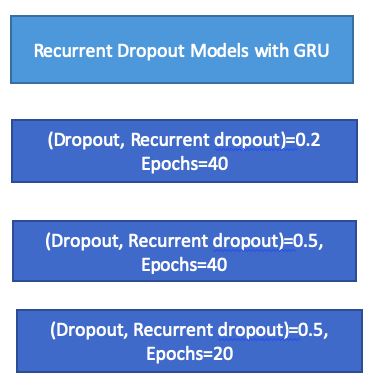


  In order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer.

  Let's apply the same and evaluate its performance.

#### **7.1 Reccurrent Dropout with GRU (dropouts=0.2,epoch=40)**

Here , we will use different set of dropouts  and evaluate the performance.
Let's start with building network based on below configuration:
* dropout=0.2
* recurrent dropout=0.2
* epoch=40


Epoch 1/40
500/500 [==============================] - 392s 779ms/step - loss: 0.3961 - val_loss: 0.2769
Epoch 2/40
500/500 [==============================] - 389s 778ms/step - loss: 0.3067 - val_loss: 0.2727
Epoch 3/40
500/500 [==============================] - 398s 796ms/step - loss: 0.2993 - val_loss: 0.2964
Epoch 4/40
500/500 [==============================] - 393s 787ms/step - loss: 0.2945 - val_loss: 0.2839
Epoch 5/40
500/500 [==============================] - 393s 787ms/step - loss: 0.2913 - val_loss: 0.2765
Epoch 6/40
500/500 [==============================] - 389s 777ms/step - loss: 0.2865 - val_loss: 0.2727
Epoch 7/40
500/500 [==============================] - 389s 778ms/step - loss: 0.2829 - val_loss: 0.2732
Epoch 8/40
500/500 [==============================] - 388s 777ms/step - loss: 0.2790 - val_loss: 0.2753
Epoch 9/40
500/500 [==============================] - 384s 768ms/step - loss: 0.2781 - val_loss: 0.2761
Epoch 10/40
500/500 [==============================] - 383s 767m

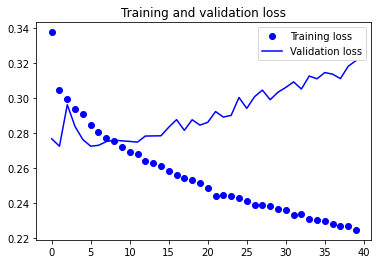

Val loss: 0.3069116473197937
train loss: 0.20638950169086456


In [ ]:
# Using reccurent dropout to fight overfitting with 0.2= dropout, recurrent dropout
import warnings
warnings.filterwarnings("ignore")
import random
warnings.filterwarnings("ignore")


random.seed(3000)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_GRU_recdrop = Sequential()
model_GRU_recdrop.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model_GRU_recdrop.add(layers.Dense(1))

model_GRU_recdrop.compile(optimizer=RMSprop(), loss='mae')
history_GRU_recdrop = model_GRU_recdrop.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_GRU_recdrop = history_GRU_recdrop.history['loss']
val_loss_GRU_recdrop = history_GRU_recdrop.history['val_loss']

epochs = range(len(loss_GRU_recdrop))

# plotting loss on validation and training
plt.figure()

plt.plot(epochs, loss_GRU_recdrop, 'bo', label='Training loss')
plt.plot(epochs, val_loss_GRU_recdrop, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation of loss on validation dataset

val_loss_GRU_recdrop = model_GRU_recdrop.evaluate_generator(val_gen, steps=50)
print('Val loss:', val_loss_GRU_recdrop)
loss_GRU_recdrop = model_GRU_recdrop.evaluate_generator(train_gen, steps=50)
print('train loss:', loss_GRU_recdrop)




#### **7.11 Observations:**
1. we can see that after epoch 5, validation loss starts to overfitting.
2. At epoch 5, MAE ~ 0.2765 it gives a mean absolute error of 2.45˚C after de-normalization.
3. The performance didn't improved , let's try changing the dropout(dropout/recurrent dropout) values from 0.2 to 0.5 and keeping the size of the epoch as 40 .




_**Note**:_ _The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be made since we are adding the condition . Therefore getting a warning for the same._


####**7.2 Reccurrent Dropout with GRU (dropouts=0.5,epoch=40)**

Here , we will use different set of dropouts  and evaluate the performance.
Let's start with building network based on below configuration:
* dropout=0.5
* recurrent dropout=0.5
* epoch=40


Epoch 1/40
500/500 [==============================] - 321s 640ms/step - loss: 0.3821 - val_loss: 0.2930
Epoch 2/40
500/500 [==============================] - 322s 644ms/step - loss: 0.3322 - val_loss: 0.2918
Epoch 3/40
500/500 [==============================] - 321s 643ms/step - loss: 0.3227 - val_loss: 0.2772
Epoch 4/40
500/500 [==============================] - 322s 643ms/step - loss: 0.3167 - val_loss: 0.2814
Epoch 5/40
500/500 [==============================] - 322s 645ms/step - loss: 0.3100 - val_loss: 0.2847
Epoch 6/40
500/500 [==============================] - 321s 643ms/step - loss: 0.3058 - val_loss: 0.2847
Epoch 7/40
500/500 [==============================] - 322s 643ms/step - loss: 0.3023 - val_loss: 0.2872
Epoch 8/40
500/500 [==============================] - 322s 645ms/step - loss: 0.2973 - val_loss: 0.2877
Epoch 9/40
500/500 [==============================] - 322s 643ms/step - loss: 0.2948 - val_loss: 0.2861
Epoch 10/40
500/500 [==============================] - 322s 645m

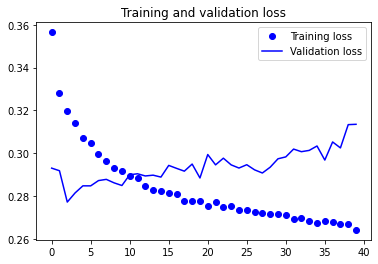

In [ ]:
# Using reccurent dropout to fight overfitting with recurrent_dropout=0.5 and  dropout =0.5 and epoch=40
import warnings
warnings.filterwarnings("ignore")
import random
warnings.filterwarnings("ignore")


random.seed(3000)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_GRU_recdrop = Sequential()
model_GRU_recdrop.add(layers.GRU(32,
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1])))
model_GRU_recdrop.add(layers.Dense(1))

model_GRU_recdrop.compile(optimizer=RMSprop(), loss='mae')
history_GRU_recdrop = model_GRU_recdrop.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_GRU_recdrop = history_GRU_recdrop.history['loss']
val_loss_GRU_recdrop = history_GRU_recdrop.history['val_loss']

epochs = range(len(loss_GRU_recdrop))

# plotting loss on validation and training
plt.figure()

plt.plot(epochs, loss_GRU_recdrop, 'bo', label='Training loss')
plt.plot(epochs, val_loss_GRU_recdrop, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#### **7.21 Observations:**

1.This model didnt performed well , it starts to overfit from epoch 15 when validation MAE = 0.2888.
2. At epoch 15, MAE ~ 0.2888 it gives a mean absolute error of 2.45˚C after de-normalization.
3. Let's evaluate the performance of the model by keeping the dropout values(dropout/recurring dropout) to 0.5 and also reducing the epoch size to 20.



_**Note**:_ _The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot do since we are adding this condition in the code . Therefore getting a warning for the same._

####**7.3 Recurrent Dropout with GRU (dropouts=0.5,epoch=20)**
Here , we will use different set of dropouts  and evaluate the performance.
Let's start with building network based on below configuration:
* dropout=0.5
* recurrent dropout=0.5
* epoch=20


Epoch 1/20
500/500 [==============================] - 315s 626ms/step - loss: 0.3979 - val_loss: 0.2980
Epoch 2/20
500/500 [==============================] - 312s 624ms/step - loss: 0.3311 - val_loss: 0.2913
Epoch 3/20
500/500 [==============================] - 314s 627ms/step - loss: 0.3214 - val_loss: 0.2826
Epoch 4/20
500/500 [==============================] - 312s 625ms/step - loss: 0.3125 - val_loss: 0.2849
Epoch 5/20
500/500 [==============================] - 312s 625ms/step - loss: 0.3138 - val_loss: 0.2938
Epoch 6/20
500/500 [==============================] - 313s 625ms/step - loss: 0.3079 - val_loss: 0.2841
Epoch 7/20
500/500 [==============================] - 312s 624ms/step - loss: 0.3040 - val_loss: 0.2887
Epoch 8/20
500/500 [==============================] - 313s 627ms/step - loss: 0.3012 - val_loss: 0.2860
Epoch 9/20
500/500 [==============================] - 314s 629ms/step - loss: 0.3024 - val_loss: 0.2858
Epoch 10/20
500/500 [==============================] - 313s 626m

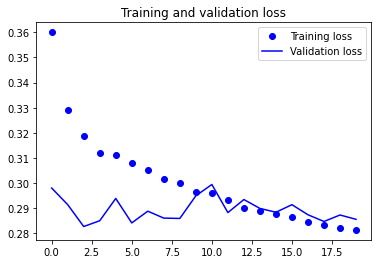

Val loss: 0.2761189341545105
train loss: 0.26914817094802856


In [ ]:
# Using reccurent dropout to fight overfitting with recurrent_dropout=0.5 and  dropout =0.5 and epochs=20
import warnings
warnings.filterwarnings("ignore")
import random
warnings.filterwarnings("ignore")


random.seed(3000)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_GRU_recdrop = Sequential()
model_GRU_recdrop.add(layers.GRU(32,
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1])))
model_GRU_recdrop.add(layers.Dense(1))

model_GRU_recdrop.compile(optimizer=RMSprop(), loss='mae')
history_GRU_recdrop = model_GRU_recdrop.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_GRU_recdrop = history_GRU_recdrop.history['loss']
val_loss_GRU_recdrop = history_GRU_recdrop.history['val_loss']

epochs = range(len(loss_GRU_recdrop))

# plotting loss on validation and training
plt.figure()

plt.plot(epochs, loss_GRU_recdrop, 'bo', label='Training loss')
plt.plot(epochs, val_loss_GRU_recdrop, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#### **7.3 Observations on recurrent using GRU:**

1. The  model  has significantly improved in terms of overfitting ,as we can see the least loss variance above.
2. We can see the balance in training loss and validation loss However, performance in terms of validation loss(MAE) has not significantly improved.



_**Note**:_ _The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be made since we are adding the condition . Therefore getting a warning for the same._


----
----

### **8. Long Short Term Memory Unit (LSTM)**
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

#### 8.1 Recurrent Dropout with LSTM


Epoch 1/20
500/500 [==============================] - 35s 36ms/step - loss: 0.3289 - val_loss: 0.2709
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2783 - val_loss: 0.2687
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2689 - val_loss: 0.2691
Epoch 4/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2592 - val_loss: 0.2711
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2518 - val_loss: 0.2697
Epoch 6/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2447 - val_loss: 0.2741
Epoch 7/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2394 - val_loss: 0.2842
Epoch 8/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2327 - val_loss: 0.2818
Epoch 9/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2279 - val_loss: 0.2861
Epoch 10/20
500/500 [==============================] - 17s 35ms/step - loss: 0.224

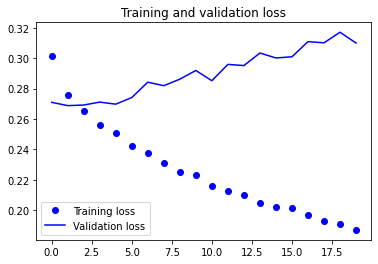

In [ ]:
# New-first reccurent baseline with LSTM
import warnings

warnings.filterwarnings("ignore")

import random
random.seed(400)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_LSTM = Sequential()
model_LSTM.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model_LSTM.add(layers.Dense(1))

model_LSTM.compile(optimizer=RMSprop(), loss='mae')
history_LSTM = model_LSTM.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)



loss_LSTM = history_LSTM.history['loss']
val_loss_LSTM = history_LSTM.history['val_loss']

epochs = range(len(loss_LSTM))


#plotting loss charts for validation and training 
plt.figure()

plt.plot(epochs, loss_LSTM, 'bo', label='Training loss')
plt.plot(epochs, val_loss_LSTM, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### **8.11 Observation:**
1. The RNN model with LSTM instead of GRU starts to ovefits after Epoch 2 .
2. The Variance between train loss and validation loss is high.
3. This problem of overfitting  needs to resolved in order to get more reliable results.

Let's use recurrent dropouts with LSTM to regularize this model.
Based on GRU models , I have decided to use only 2 combinations for recurrent dropouts for LSTM.





<br>




#### **8.2 Recurrent Dropouts on LSTM**

Here , we will use different set of units on each layers and evaluate the performance.Let's start with building network based on below configuration:
* dropout=0.2
* recurrent dropout=0.2
* epoch=40

Epoch 1/40
500/500 [==============================] - 153s 302ms/step - loss: 0.3516 - val_loss: 0.2707
Epoch 2/40
500/500 [==============================] - 147s 295ms/step - loss: 0.2909 - val_loss: 0.2708
Epoch 3/40
500/500 [==============================] - 147s 295ms/step - loss: 0.2829 - val_loss: 0.2795
Epoch 4/40
500/500 [==============================] - 146s 292ms/step - loss: 0.2764 - val_loss: 0.2752
Epoch 5/40
500/500 [==============================] - 148s 296ms/step - loss: 0.2680 - val_loss: 0.2812
Epoch 6/40
500/500 [==============================] - 146s 293ms/step - loss: 0.2631 - val_loss: 0.2875
Epoch 7/40
500/500 [==============================] - 146s 293ms/step - loss: 0.2598 - val_loss: 0.2876
Epoch 8/40
500/500 [==============================] - 146s 292ms/step - loss: 0.2559 - val_loss: 0.2902
Epoch 9/40
500/500 [==============================] - 150s 300ms/step - loss: 0.2513 - val_loss: 0.2878
Epoch 10/40
500/500 [==============================] - 147s 295m

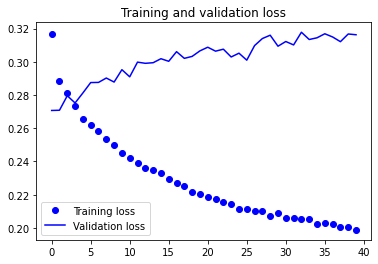

In [ ]:
# New - Using reccurent dropout to fight overfitting with LSTM
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import warnings

warnings.filterwarnings("ignore")
import random

random.seed(5001)

model_LSTM_recdrop = Sequential()
model_LSTM_recdrop.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model_LSTM_recdrop.add(layers.Dense(1))

model_LSTM_recdrop.compile(optimizer=RMSprop(), loss='mae')
history_LSTM_recdrop = model_LSTM_recdrop.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_LSTM_recdrop = history_LSTM_recdrop.history['loss']
val_loss_LSTM_recdrop = history_LSTM_recdrop.history['val_loss']

epochs = range(len(loss_LSTM_recdrop))

# plotting loss on validation and training
plt.figure()

plt.plot(epochs, loss_LSTM_recdrop, 'bo', label='Training loss')
plt.plot(epochs, val_loss_LSTM_recdrop, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#### **8.21 Observations:**

1.This LSTM model shows overfitting from epoch 6.

2.At epoch 6, MAE ~ 0.2791 it gives a mean absolute error of 2.47˚C after de-normalization.

The performance didn't improved , let's try changing the dropout(dropout/recurrent dropout) values from 0.2 to 0.5 and keeping the size of the epoch as 20 .



_**Note**:_ _Warning: The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be done,  since we need to add this condition in the code. Therefore getting a warning for the same.(Doesn't come for this as we have used TPU instead of GPU)_

####**8.3 Recurrent dropout Model2 with LSTM**
Here , we will use different set of units on each layers and evaluate the performance.Let's start with building network based on below configuration:
* dropout= 0.5
* recurrent dropout=0.5
* Epoch=20


Epoch 1/20
500/500 [==============================] - 386s 769ms/step - loss: 0.3824 - val_loss: 0.2824
Epoch 2/20
500/500 [==============================] - 398s 797ms/step - loss: 0.3154 - val_loss: 0.2820
Epoch 3/20
500/500 [==============================] - 396s 792ms/step - loss: 0.3033 - val_loss: 0.2765
Epoch 4/20
500/500 [==============================] - 373s 747ms/step - loss: 0.3000 - val_loss: 0.2856
Epoch 5/20
500/500 [==============================] - 374s 747ms/step - loss: 0.2955 - val_loss: 0.2789
Epoch 6/20
500/500 [==============================] - 369s 738ms/step - loss: 0.2898 - val_loss: 0.2816
Epoch 7/20
500/500 [==============================] - 377s 755ms/step - loss: 0.2845 - val_loss: 0.2820
Epoch 8/20
500/500 [==============================] - 386s 772ms/step - loss: 0.2836 - val_loss: 0.2863
Epoch 9/20
500/500 [==============================] - 414s 828ms/step - loss: 0.2791 - val_loss: 0.2875
Epoch 10/20
500/500 [==============================] - 395s 789m

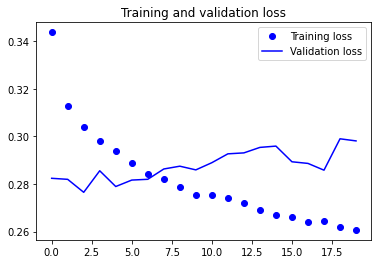

In [ ]:
# New - Using reccurent dropout to fight overfitting with LSTM with recurrent dropout=0.5, dropout=0.5
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
warnings.filterwarnings("ignore")

random.seed(500)

model_LSTM_recdrop = Sequential()
model_LSTM_recdrop.add(layers.LSTM(32,
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1])))
model_LSTM_recdrop.add(layers.Dense(1))

model_LSTM_recdrop.compile(optimizer=RMSprop(), loss='mae')
history_LSTM_recdrop = model_LSTM_recdrop.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_LSTM_recdrop = history_LSTM_recdrop.history['loss']
val_loss_LSTM_recdrop = history_LSTM_recdrop.history['val_loss']

epochs = range(len(loss_LSTM_recdrop))

# plotting loss on validation and training
plt.figure()

plt.plot(epochs, loss_LSTM_recdrop, 'bo', label='Training loss')
plt.plot(epochs, val_loss_LSTM_recdrop, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


####**8.31 Observations:**

1.This LSTM model shows overfitting from epoch 6.The Validation loss begins to go up after epoch 5.

2.At epoch 5, MAE ~ 0.2789 it gives a mean absolute error of 2.47˚C after de-normalization.

The performance didn't improved , let's try changing the dropout(dropout/recurrent dropout) values from 0.2 to 0.5 and keeping the size of the epoch as 20 .

_**Note**:_

_1. The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be made since we are adding the condition . Therefore getting a warning for the same._

---
---

### **9. Stacked Recurrent Layers with GRU**

In stacked Recurrent layer models, each  layer outputs a sequence of vectors which will be used as an input to a subsequent model layer. This hierarchy of hidden layers enables more complex representation of our time-series data, capturing information at different scales.

<br>

#### **Approach:**
Evaluated below 4 different stacked recurrent layers models:

<br>

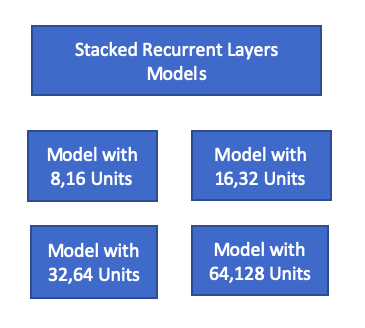

#### **9.1 Stacking Reccurrent layers(unit size 32,64)**
Here , we will use different set of units on each layers and evaluate the performance.Let's start with building network based on below configuration on each layer:
* Unit size= 32,64
* dropout=0.1 ,dropout=0.5
* epochs = 20

Epoch 1/20
500/500 [==============================] - 660s 1s/step - loss: 0.3388 - val_loss: 0.2815
Epoch 2/20
500/500 [==============================] - 652s 1s/step - loss: 0.3044 - val_loss: 0.2725
Epoch 3/20
500/500 [==============================] - 657s 1s/step - loss: 0.2946 - val_loss: 0.2743
Epoch 4/20
500/500 [==============================] - 652s 1s/step - loss: 0.2905 - val_loss: 0.2824
Epoch 5/20
500/500 [==============================] - 654s 1s/step - loss: 0.2852 - val_loss: 0.2677
Epoch 6/20
500/500 [==============================] - 652s 1s/step - loss: 0.2765 - val_loss: 0.2748
Epoch 7/20
500/500 [==============================] - 652s 1s/step - loss: 0.2714 - val_loss: 0.2738
Epoch 8/20
500/500 [==============================] - 649s 1s/step - loss: 0.2664 - val_loss: 0.2731
Epoch 9/20
500/500 [==============================] - 652s 1s/step - loss: 0.2621 - val_loss: 0.2820
Epoch 10/20
500/500 [==============================] - 668s 1s/step - loss: 0.2592 - val_lo

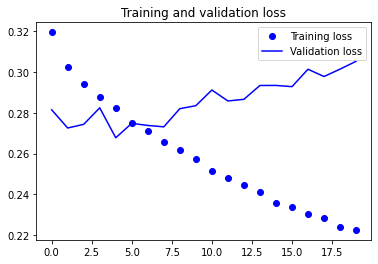

In [ ]:
# stacking reccurent layers GRU

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
warnings.filterwarnings("ignore")

random.seed(600)

model_stack = Sequential()
model_stack.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model_stack.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model_stack.add(layers.Dense(1))

model_stack.compile(optimizer=RMSprop(), loss='mae')
history_stack = model_stack.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_stack = history_stack.history['loss']
val_loss_stack = history_stack.history['val_loss']

epochs = range(len(loss_stack))
# plotting loss for validation and training
plt.figure()

plt.plot(epochs, loss_stack, 'bo', label='Training loss')
plt.plot(epochs, val_loss_stack, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


####**9.1 Observations:**
1. After Epoch =5 , model starts to overfit.
2. MAE = 0.2677, 2.37 degree celcius.





_**Note**:_ _The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be done ,since we are adding this condition in the code. Therefore getting a warning for the same._

<br>
<br>


#### **9.2 Stacking Reccurrent layer (unit size=16,32)**



Here , we will use different set of units on each layers and evaluate the performance.Let's start with building network based on below configuration:

* dropout=0.5 ,dropout=0.5
* epochs = 20
* Changing the **units to 16 and 32** for first layer and second layer respectively.

Epoch 1/20
500/500 [==============================] - 692s 1s/step - loss: 0.4187 - val_loss: 0.3142
Epoch 2/20
500/500 [==============================] - 697s 1s/step - loss: 0.3467 - val_loss: 0.2946
Epoch 3/20
500/500 [==============================] - 694s 1s/step - loss: 0.3336 - val_loss: 0.2949
Epoch 4/20
500/500 [==============================] - 695s 1s/step - loss: 0.3269 - val_loss: 0.2960
Epoch 5/20
500/500 [==============================] - 721s 1s/step - loss: 0.3217 - val_loss: 0.2977
Epoch 6/20
500/500 [==============================] - 698s 1s/step - loss: 0.3166 - val_loss: 0.2917
Epoch 7/20
500/500 [==============================] - 696s 1s/step - loss: 0.3150 - val_loss: 0.2932
Epoch 8/20
500/500 [==============================] - 696s 1s/step - loss: 0.3120 - val_loss: 0.2975
Epoch 9/20
500/500 [==============================] - 706s 1s/step - loss: 0.3089 - val_loss: 0.2888
Epoch 10/20
500/500 [==============================] - 719s 1s/step - loss: 0.3070 - val_lo

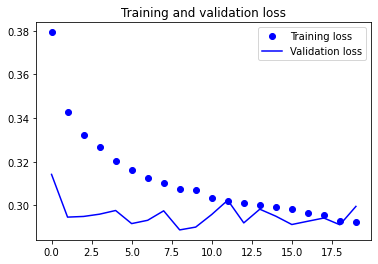

In [ ]:

# stacking reccurent layers
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
warnings.filterwarnings("ignore")

random.seed(600)

model_stack2 = Sequential()
model_stack2.add(layers.GRU(16,
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model_stack2.add(layers.GRU(32, activation='relu',
                     dropout=0.5, 
                     recurrent_dropout=0.5))
model_stack2.add(layers.Dense(1))

model_stack2.compile(optimizer=RMSprop(), loss='mae')
history_stack2 = model_stack2.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_stack2 = history_stack2.history['loss']
val_loss_stack2 = history_stack2.history['val_loss']

epochs = range(len(loss_stack2))
# plotting loss for validation and training
plt.figure()

plt.plot(epochs, loss_stack2, 'bo', label='Training loss')
plt.plot(epochs, val_loss_stack2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



#### **9.21 Observation:**
1. This model has performed better in terms of overfitting, by Epoch 20 validation loss and traning loss becomes almost same.
2.At Epoch 9 the MAE reaches 0.2888 giving a total of 2.56 degree celcius.

let's try to reduce the number of units little further and evaluate the results.



_**Note**:_ _The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be done , since we need to use this condition in the code. Therefore getting a warning for the same._

<br>
<br>


#### **9.3 Stacking reccurrent layer(unit size=8,16)**

Here , we will use different set of units on each layers and evaluate the performance.Let's start with building network based on below configuration:

* changing the units to 8 and 16 for first and second layer respectively.
* epochs=20


Epoch 1/20
500/500 [==============================] - 668s 1s/step - loss: 0.4642 - val_loss: 0.3309
Epoch 2/20
500/500 [==============================] - 662s 1s/step - loss: 0.3685 - val_loss: 0.3165
Epoch 3/20
500/500 [==============================] - 665s 1s/step - loss: 0.3518 - val_loss: 0.2996
Epoch 4/20
500/500 [==============================] - 666s 1s/step - loss: 0.3428 - val_loss: 0.2970
Epoch 5/20
500/500 [==============================] - 665s 1s/step - loss: 0.3353 - val_loss: 0.2956
Epoch 6/20
500/500 [==============================] - 667s 1s/step - loss: 0.3317 - val_loss: 0.2996
Epoch 7/20
500/500 [==============================] - 666s 1s/step - loss: 0.3270 - val_loss: 0.3047
Epoch 8/20
500/500 [==============================] - 670s 1s/step - loss: 0.3275 - val_loss: 0.2980
Epoch 9/20
500/500 [==============================] - 664s 1s/step - loss: 0.3239 - val_loss: 0.2965
Epoch 10/20
500/500 [==============================] - 663s 1s/step - loss: 0.3232 - val_lo

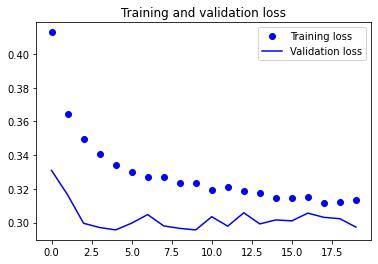

In [ ]:

# stacking reccurent layers
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
warnings.filterwarnings("ignore")

random.seed(6000)

model_stack3 = Sequential()
model_stack3.add(layers.GRU(8,
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model_stack3.add(layers.GRU(16, activation='relu',
                     dropout=0.5, 
                     recurrent_dropout=0.5))
model_stack3.add(layers.Dense(1))

model_stack3.compile(optimizer=RMSprop(), loss='mae')
history_stack3 = model_stack3.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_stack3 = history_stack3.history['loss']
val_loss_stack3 = history_stack3.history['val_loss']

epochs = range(len(loss_stack3))
# plotting loss for validation and training
plt.figure()

plt.plot(epochs, loss_stack3, 'bo', label='Training loss')
plt.plot(epochs, val_loss_stack3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


#### **Observations for stacked recurrent baseline:**

1. Overfitting has been reduced significantly however , the validation loss has increased.

2. The variance of training loss and Validation loss has reduced, also the validation loss has reduced.





_**Note**:_ _The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be done since we need to use this condition in the code. Therefore getting a warning for the same._

---



#### **9.4 Stacking  reccurrent layers (unit size=64,128)**

Here , we will use different set of units on each layers and evaluate the performance.
Let's start with building network based on below configuration:

* changing the units to 64 and 128 for first and second layer respectively.
* epochs=20

In [ ]:
# increasing the size of units

# stacking reccurent layers
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
warnings.filterwarnings("ignore")

random.seed(6004)

model_stack4 = Sequential()
model_stack4.add(layers.GRU(64,
                     dropout=0.5,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model_stack4.add(layers.GRU(128, activation='relu',
                     dropout=0.5, 
                     recurrent_dropout=0.5))
model_stack4.add(layers.Dense(1))

model_stack4.compile(optimizer=RMSprop(), loss='mae')
history_stack4 = model_stack4.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_stack4 = history_stack4.history['loss']
val_loss_stack4 = history_stack4.history['val_loss']

epochs = range(len(loss_stack4))

# plotting loss for validation and training
plt.figure()

plt.plot(epochs, loss_stack4, 'bo', label='Training loss')
plt.plot(epochs, val_loss_stack4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



Epoch 1/20
500/500 [==============================] - 512s 1s/step - loss: 0.3687 - val_loss: 0.2986
Epoch 2/20
500/500 [==============================] - 503s 1s/step - loss: 0.3269 - val_loss: 0.2988
Epoch 3/20
500/500 [==============================] - 504s 1s/step - loss: 0.3088 - val_loss: 0.2964
Epoch 4/20
500/500 [==============================] - 504s 1s/step - loss: 0.2991 - val_loss: 0.2881
Epoch 5/20
500/500 [==============================] - 508s 1s/step - loss: 0.2934 - val_loss: 0.2889
Epoch 6/20
500/500 [==============================] - 505s 1s/step - loss: 0.2871 - val_loss: 0.2871
Epoch 7/20
500/500 [==============================] - 508s 1s/step - loss: 0.2800 - val_loss: 0.3001
Epoch 8/20
500/500 [==============================] - 510s 1s/step - loss: 0.2734 - val_loss: 0.3019
Epoch 9/20
500/500 [==============================] - 528s 1s/step - loss: 0.2677 - val_loss: 0.3088
Epoch 10/20
500/500 [==============================] - 555s 1s/step - loss: 0.2597 - val_lo

####**9.4 Observation:**
1. The overfitting started after **Epoch 6**. 
2. The Validation loss is in the of 0.30's, which is very high  and we are looking to get the least or a better performance than the basic machine learning model.
3. MAE at Epoch 6 is **0.2871**,,there the total MAE celsius(celsius error)will be **2.54 degree celsius**.

####**Result:**
Below table shows the performance comparisons of the stacked layer models(Execution time is in seconds):

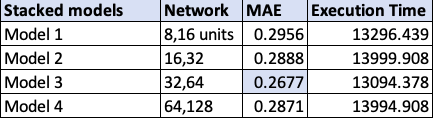

Model with units 32 and 64 for first and second layer respectively has the least MAE.

### **10. Bidirectional RNN**
Bidirectional recurrent neural networks (BRNN) connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past (backwards) and future (forward) states simultaneously.

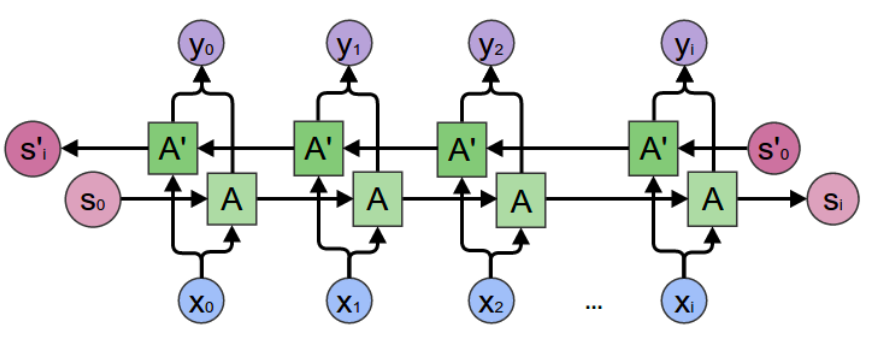


A BRNN is a combination of two RNNs - one RNN moves forward, beginning from the start of the data sequence, and the other, moves backward, beginning from the end of the data sequence. By processing a sequence both ways(chronologically and antichronologically), a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.


Epoch 1/20
500/500 [==============================] - 16s 29ms/step - loss: 0.4966 - val_loss: 0.4791
Epoch 2/20
500/500 [==============================] - 14s 29ms/step - loss: 0.4618 - val_loss: 0.4701
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4387 - val_loss: 0.4596
Epoch 4/20
500/500 [==============================] - 14s 28ms/step - loss: 0.4014 - val_loss: 0.4264
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3614 - val_loss: 0.4306
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3368 - val_loss: 0.4042
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3154 - val_loss: 0.3990
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2985 - val_loss: 0.3976
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2861 - val_loss: 0.4018
Epoch 10/20
500/500 [==============================] - 14s 28ms/step - loss: 0.281

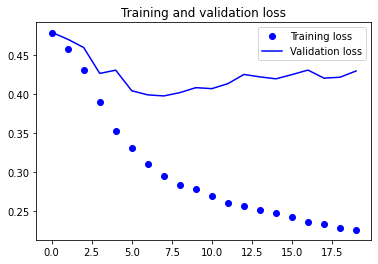

Val loss: 0.5209470987319946


In [ ]:
warnings.filterwarnings("ignore")

random.seed(800)

# using Bidirectional RNN's
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)
model_bi = Sequential()
model_bi.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model_bi.add(layers.Dense(1))

model_bi.compile(optimizer=RMSprop(), loss='mae')
history_bi = model_bi.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

loss_bi = history_bi.history['loss']
val_loss_bi = history_bi.history['val_loss']

epochs = range(len(loss_bi))

# Plotting loss on validation and training 
plt.figure()

plt.plot(epochs, loss_bi, 'bo', label='Training loss')
plt.plot(epochs, val_loss_bi, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation of loss on validation dataset

val_loss_bi = model_bi.evaluate_generator(val_gen, steps=50)
print('Val loss:', val_loss_bi)


####**10.2 Observations on Bidirectional Approach :**

1. The validation loss remains in the range of 0.40's, which is very high  and shows poor peformance.

2. The reversed-order GRU strongly underperforms  indicating that the bidirectional apprach is not suitable for this type  dataset and therfore  in we can say that chronological processing is very important to achieve better results .

3. The underlying GRU layer  in the bidirectional approach will typically be better at remembering the recent past than the distant past, 
In the current dataset, the more recent weather data points are more predictive than older data points in current.

4. Therefore, the chronological version of the layer is likely to outperform the reversed-order version.

Below pictures depicts the process followed in  chronological RNN:

 

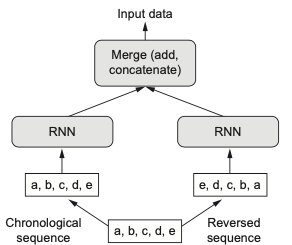


Let's try implementing chronological order on the model and evaluate the results.

 ### **11. Chronological RNN**



In [15]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
warnings.filterwarnings("ignore")

random.seed(900)

model_bi_chro = Sequential()
model_bi_chro.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model_bi_chro.add(layers.Dense(1))

model_bi_chro.compile(optimizer=RMSprop(), loss='mae')
history_bi_chro = model_bi_chro.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss_bi_chro = history_bi_chro.history['loss']
val_loss_bi_chro = history_bi_chro.history['val_loss']

epochs = range(len(loss_bi_chro))


Epoch 1/40
500/500 [==============================] - 98s 190ms/step - loss: 0.3165 - val_loss: 0.2708
Epoch 2/40
500/500 [==============================] - 95s 191ms/step - loss: 0.2759 - val_loss: 0.2644
Epoch 3/40
500/500 [==============================] - 95s 189ms/step - loss: 0.2676 - val_loss: 0.2637
Epoch 4/40
500/500 [==============================] - 95s 189ms/step - loss: 0.2633 - val_loss: 0.2683
Epoch 5/40
500/500 [==============================] - 94s 188ms/step - loss: 0.2587 - val_loss: 0.2789
Epoch 6/40
500/500 [==============================] - 96s 191ms/step - loss: 0.2536 - val_loss: 0.2652
Epoch 7/40
500/500 [==============================] - 95s 190ms/step - loss: 0.2466 - val_loss: 0.2686
Epoch 8/40
500/500 [==============================] - 95s 191ms/step - loss: 0.2402 - val_loss: 0.2736
Epoch 9/40
500/500 [==============================] - 97s 193ms/step - loss: 0.2345 - val_loss: 0.2809
Epoch 10/40
500/500 [==============================] - 95s 190ms/step - l

#### **11.2 Observations:**
1. This model is definately overfits .
2. After Epoch 2 , MAE = 0.2657 giving a total of MAE celcius of 2.35 degree celsius.
3. This performs about as well as the regular GRU layer. 


---
---
<br>



### **12. 1D convets with RNN**

It is an effective technique to combine to  the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before an RNN .This sequence of extracted features then becomes the input to the RNN part of the network.

Below  picture depicts combining a 1D convnet and an RNN for processing long sequences:-


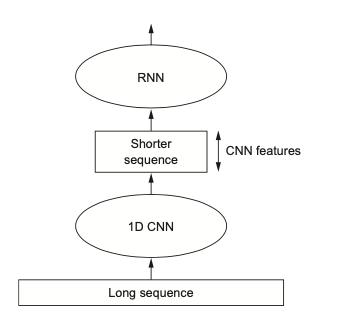






Epoch 1/20
500/500 [==============================] - 15s 26ms/step - loss: 0.4595 - val_loss: 0.4677
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3687 - val_loss: 0.4565
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.3411 - val_loss: 0.4569
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3229 - val_loss: 0.5040
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3095 - val_loss: 0.4567
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3019 - val_loss: 0.4676
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2908 - val_loss: 0.4713
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2866 - val_loss: 0.4660
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2766 - val_loss: 0.4809
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.273

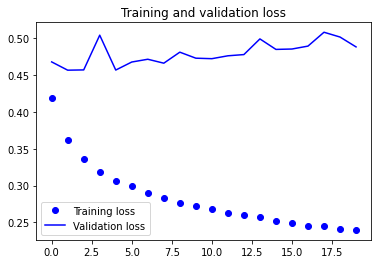

Val loss: 0.39127278327941895


In [ ]:

#Training and evaluating a simple 1D convnet on the Jena data

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

warnings.filterwarnings("ignore")

random.seed(1000)

model_1D = Sequential()
model_1D.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model_1D.add(layers.MaxPooling1D(3))
model_1D.add(layers.Conv1D(32, 5, activation='relu'))
model_1D.add(layers.MaxPooling1D(3))
model_1D.add(layers.Conv1D(32, 5, activation='relu'))
model_1D.add(layers.GlobalMaxPooling1D())
model_1D.add(layers.Dense(1))

model_1D.compile(optimizer=RMSprop(), loss='mae')
history_1D = model_1D.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


                              
import matplotlib.pyplot as plt

loss_1D = history_1D.history['loss']
val_loss_1D = history_1D.history['val_loss']

epochs = range(len(loss_1D))

plt.figure()

plt.plot(epochs, loss_1D, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1D, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 1627s 3s/step - loss: 0.3896 - val_loss: 0.3051
Epoch 2/20
500/500 [==============================] - 1629s 3s/step - loss: 0.3171 - val_loss: 0.2865
Epoch 3/20
500/500 [==============================] - 1607s 3s/step - loss: 0.2997 - val_loss: 0.2688
Epoch 4/20
500/500 [==============================] - 1618s 3s/step - loss: 0.2918 - val_loss: 0.2923
Epoch 5/20
500/500 [==============================] - 1602s 3s/step - loss: 0.2830 - val_loss: 0.2764
Epoch 6/20
500/500 [==============================] - 1607s 3s/step - loss: 0.2811 - val_loss: 0.2817
Epoch 7/20
500/500 [==============================] - 1600s 3s/step - loss: 0.2743 - val_loss: 0.2733
Epoch 8/20
500/500 [==============================] - 1597s 3s/step - loss: 0.2699 - val_loss: 0.2763
Epoch 9/20
500/500 [==============================] - 1615s 3s/step - loss: 0.2627 - val_loss: 0.2744
Epoch 10/20
500/500 [==============================] - 1597s 3s/step - loss: 0.2583 - val_los

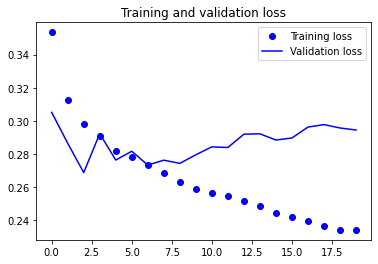

In [ ]:
#Preparing higher-resolution data generators for the Jena dataset

step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps1 = (300000 - 200001 - lookback) 
test_steps1 = (len(float_data) - 300001 - lookback) 


from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop


model_1D = Sequential()
model_1D.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1]))) 

model_1D.add(layers.MaxPooling1D(3))
model_1D.add(layers.Conv1D(32, 5, activation='relu')) 
model_1D.add(layers.GRU(32, dropout=0.5, recurrent_dropout=0.5))
model_1D.add(layers.Dense(1))
model_1D.summary() 
model_1D.compile(optimizer=RMSprop(), loss='mae')

history_1D = model_1D.fit_generator(train_gen, steps_per_epoch=500,
                                      epochs=20,
                                      validation_data=val_gen,
                                      validation_steps=val_steps1)


import matplotlib.pyplot as plt

loss_1D = history_1D.history['loss']
val_loss_1D = history_1D.history['val_loss']

epochs = range(len(loss_1D))

plt.figure()

plt.plot(epochs, loss_1D, 'bo', label='Training loss')
plt.plot(epochs, val_loss_1D, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



#### **12.2 Observations on 1D convets with RNN:**
1. The Validation loss is in the range of  0.20's.
2. The Validation loss doesnt seems to be improve by any significant score.
3. Suprisingly, 1D convnets consumed 10hrs to complete the execution and did'nt resulted into significant results.
4. The model starts to overfit after epoch 3, where MAE is **0.2688**.Therefore,leading to MAE celsius to **2.38 degree celsius**.
5. Typically **1D convnets** are structured much like their 2D equivalents from the world of computer vision.


_**Note**:_

_1. The requirements to use the cuDNN implementation includes recurrent_dropout == 0 , which cannot be done ,since we need to use this condition on the code. Therefore getting a warning for the same._

_2. increased dropout value from 0.2 to 0.5(the execution was extreamly slow,1hr=1epoch,GPU was used)_


### **13. Applying Best Models on Test Data:**

In [16]:
# Evaluating model on the test data
test_loss = model_GRU.evaluate_generator(test_gen, steps=929)
print('test loss for base machine learning model:', test_loss)

#test_loss,  = model_1D.evaluate_generator(test_gen, steps=50)
#print('test loss based on 1D convents RNN:', test_loss)

test_loss2  = model_bi_chro.evaluate_generator(test_gen, steps=929)
print('test loss for chronological model:', test_loss2)


test loss for base machine learning model: 0.30758851766586304
test loss for chronological model: 0.3518730103969574


###**Summary Report:**



1. The  baseline model(Simple non- machine learning model) provides a base for performance evaluation. It helps in analyzing any real progress on the advance models.
2. The **simple machine learning models** turned out to be one of the **best** models .It is simple with **less computational expenses**.
3. Recurrent dropout networks helps in reducing **overfitting** of the flatten layered (simple machine learning GRU model).

4. **Stacked RNNs** are known to have  more representational power than a single RNN layer, however they **didn't outperformed** in this case.Execution of these program were very time consuming with no significant improvemnt in the performance of the model. The Time-series data might be simpler data for it as they perform well on complex dataset and problems like machine transalation.

5. **Bidirectional RNNs**, were not among the best performance models. They actual **performed worst** among other models.The reason can be that they are **not strong performer on sequence data**.

6. Chronological Model performed **equivalent to the simple machine learning model** and was of the best in performance evaluation
7. 1D convnets are were a good option to include them with RNN as a preprocessing step.It helped in shortening the sequence and extracting useful informations for RNN's to process further.
8. There were quite a few models with very close MAE results, however only top two were choosen for test data.
8. Please find below table the performance evaluation  of all the models.(Execution is in seconds)




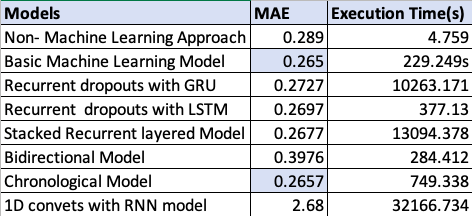
9. Based on the above performance of different models, 2 of them were choosen with least MAE to test the test data.

* Test loss for **base machine learning model**: 0.30758851766586304

* Test loss for **chronological model**: 0.3518730103969574

<br>
<br>
<br>

---
---


<br>

**_References:_**

Book[ François Chollet,Deep Learning with Python]


https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b

https://ieeexplore.ieee.org/document/9221727

https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm

https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/mean-absolute-error

https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks

https://blog.paperspace.com/bidirectional-rnn-keras/

https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470

https://medium.com/@jon.froiland/advanced-use-of-recurrent-neural-networks-part-6-f6c44cdc7d71#:~:text=Using%20Recurrent%20Dropout%20to%20Fight%20Overfitting,-It's%20evident%20from&text=You're%20already%20familiar%20with,the%20layer%20is%20exposed%20to.

---
s










